In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats import kurtosis, skew
import gc
import json
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from pathlib import Path
import sys
import re

from scripts import feature_engineering

In [3]:
path=Path('/kaggle/data_science_bowl')
path

PosixPath('/kaggle/data_science_bowl')

In [4]:
def read_data():
    train_df = pd.read_csv(path/'train.csv')
    test_df = pd.read_csv(path/'test.csv')
    train_labels_df = pd.read_csv(path/'train_labels.csv')
    specs_df = pd.read_csv(path/'specs.csv')
    return train_df, test_df, train_labels_df, specs_df

In [5]:
%%time
train_df, test_df, train_labels_df, specs_df = read_data()

CPU times: user 36.1 s, sys: 2.43 s, total: 38.6 s
Wall time: 41.3 s


## Feature Engineering

### Cleanup

In [6]:
train_df = feature_engineering.remove_wrong_event_codes(train_df)
test_df = feature_engineering.remove_wrong_event_codes(test_df)

In [7]:
train_df = feature_engineering.remove_ids_with_no_assessment(train_df)

In [8]:
list_of_user_activities, activities_labels, activities_map, win_code, assess_titles, list_of_event_code, \
list_of_event_id, list_of_worlds, list_of_title, list_of_event_code_world, list_of_event_code_title, list_of_event_id_world = \
feature_engineering.create_structs(train_df, test_df)

In [9]:
# train_df = train_df.rename({'event_code_title':'title_event_code'}, axis='columns')
# test_df = test_df.rename({'event_code_title':'title_event_code'}, axis='columns')

In [10]:
train_samples = [(installation_id, user_sample) for (installation_id, user_sample) in train_df.groupby('installation_id')]
test_samples = [(installation_id, user_sample) for (installation_id, user_sample) in test_df.groupby('installation_id')]

In [11]:
comp_train_df = feature_engineering.feature_generation(train_samples, False,
                                                       assess_titles=assess_titles, list_of_event_code=list_of_event_code,
                                                       list_of_event_id=list_of_event_id, list_of_worlds=list_of_worlds,
                                                       list_of_title=list_of_title, win_code=win_code, 
                                                       activities_map=activities_map, 
                                                       list_of_event_code_world=list_of_event_code_world,
                                                       list_of_event_code_title=list_of_event_code_title,
                                                       list_of_event_id_world=list_of_event_id_world)
# comp_train_df = feature_engineering.feature_generation_2(train_samples, False, assess_titles=assess_titles,
#                                                          list_of_event_code=list_of_event_code, list_of_event_id=list_of_event_id,
#                                                          activities_labels=activities_labels, all_title_event_code=list_of_event_code_title,
#                                                          win_code=win_code,
#                                                          activities_map=activities_map)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/fastai/fastai-exercises/nbs_gil/data_science_bowl/scripts/feature_engineering.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session["passed"] = session.loc[:, "timestamp"].diff().apply(lambda x: x.seconds)


In [12]:
comp_train_df

,Clip,Activity,Assessment,Game,game_session,Clip_time_mean,Activity_time_mean,Assessment_time_mean,Game_time_mean,duration_mean,title_duration_meanChest Sorter (Assessment),title_duration_meanMushroom Sorter (Assessment),title_duration_meanBird Measurer (Assessment),title_duration_meanCauldron Filler (Assessment),title_duration_meanCart Balancer (Assessment),activity_game_time_Clip,activity_game_time_Activity,activity_game_time_Assessment,activity_game_time_Game,8d7e386c,ca11f653,58a0de5c,5290eab1,67439901,db02c830,2230fab4,49ed92e9,99abe2bb,9ed8f6da,f6947f54,c74f40cd,5b49460a,c6971acf,1af8be29,29a42aea,a5be6304,c51d8688,f50fc6c1,6077cc36,f806dc10,0086365d,8ac7cce4,6cf7d25c,2fb91ec1,f28c589a,3afb49e6,08ff79ad,f5b8c21a,74e5f8a7,731c0cbe,f7e47413,b80e5e84,6f4adc4b,587b5989,ac92046e,1c178d24,bbfe0445,86ba578b,9e6b7fb5,c189aaf2,28a4eb9a,2a444e03,a16a373e,e720d930,84b0e0c8,33505eae,5f5b2617,f56e0afc,a1192f43,65abac75,17113b36,daac11b0,907a054b,363c86c9,48349b14,2ec694de,77c76bc5,6f8106d9,53c6e11a,a8efe47b,4d6737eb,3babcb9b,c7fe2a55,7525289a,47efca07,d122731b,df4940d3,9554a50b,3d8c61b0,e5c9df6f,d88e8f25,a1e4395d,d3268efa,6aeafed4,b74258a0,26fd2d99,792530f8,9ce586dd,5348fd84,e64e2cfd,756e5507,461eace6,b7530680,3d0b9317,90ea0bac,71fe8f75,56bcd38d,cf82af56,b2dba42b,d2e9262e,6bf9e3e1,67aa2ada,cdd22e43,bd612267,a0faea5d,01ca3a3c,3ccd3f02,5f0eb72c,3323d7e9,06372577,46cd75b4,abc5811c,7da34a02,3a4be871,37ee8496,7d093bf9,d38c2fd7,d2278a3b,250513af,14de4c5d,73757a5e,9b4001e4,499edb7c,7040c096,d51b1749,65a38bf7,1cc7cfca,29f54413,f54238ee,31973d56,3bb91dda,6f4bd64e,c58186bf,e7561dd2,dcaede90,565a3990,ecc36b7f,93edfe2e,392e14df,fbaf3456,6f445b57,8af75982,99ea62f3,a7640a16,2dc29e21,fd20ea40,c0415e5c,47026d5f,8d748b58,1f19558b,6088b756,b88f38da,3d63345e,cfbd47c8,92687c59,5d042115,85de926c,a8a78786,e57dd7af,ea296733,de26c3a6,08fd73f3,795e4a37,1cf54632,15f99afc,a52b92d5,29bdd9ba,5c2f29ca,1340b8d7,37db1c2f,0db6d71d,1beb320a,ab3136ba,ecc6157f,83c6c409,beb0a7b9,d2659ab4,155f62a4,a5e9da97,6c930e6e,c7f7f0e1,2b9272f4,15a43e5b,d185d3ea,5de79a6a,13f56524,05ad839b,e080a381,4b5efe37,3ee399c3,e37a2b78,9e34ea74,884228c8,a8876db3,a6d66e51,3bf1cf26,cb1178ad,c54cf6c5,15eb4a7d,4e5fc6f5,598f4598,e4d32835,ab4ec3a4,8b757ab8,fcfdffb6,d3f1e122,28ed704e,562cec5f,47f43a44,bfc77bd6,25fa8af4,17ca3959,9de5e594,ec138c1c,51102b85,0d18d96c,1b54d27f,cf7638f3,acf5c23f,7dfe6d8a,3edf6747,d45ed6a1,8d84fa81,ea321fb1,5c3d2b2f,3dfd4aa4,b2e5b0f1,7cf1bc53,dcb55a27,93b353f2,4bb2f698,d9c005dd,26a5a3dd,ad2fc29c,16dffff1,857f21c0,7f0836bf,00c73085,16667cc5,d02b7a8e,...,3020Dino Drink,2000Pan Balance,4100Chest Sorter (Assessment),3110Chicken Balancer (Activity),4090Chow Time,2030Air Show,4025Egg Dropper (Activity),4220Bubble Bath,4035Mushroom Sorter (Assessment),3010Dino Drink,4070Bug Measurer (Activity),4030Pan Balance,4090Air Show,4080Fireworks (Activity),4030Chow Time,4090Crystals Rule,2030Cauldron Filler (Assessment),4080Bubble Bath,3110Flower Waterer (Activity),4030Chicken Balancer (Activity),4080Bottle Filler (Activity),3120Cart Balancer (Assessment),4090Bug Measurer (Activity),4010All Star Sorting,2010Pan Balance,3010Sandcastle Builder (Activity),4020Bubble Bath,3010Chest Sorter (Assessment),3121All Star Sorting,3110Cauldron Filler (Assessment),4010Dino Drink,4020Pan Balance,4020Leaf Leader,3121Crystals Rule,3110Fireworks (Activity),2030Cart Balancer (Assessment),2070Air Show,4030Bird Measurer (Assessment),2000Honey Cake,3110Scrub-A-Dub,4040Cauldron Filler (Assessment),3120Pan Balance,4090Dino Dive,3021Scrub-A-Dub,2000Air Show,4035Cart Balancer (Assessment),4090Scrub-A-Dub,2020Bottle Filler (Activity),4095Chow Time,2000Lifting Heavy Things,3120Mushroom Sorter (Assessment),4100Air Show,3120Crystals Rule,4070Dino Drink,3110Chow Time,3110Watering Hole (Activity),2000Bubble Bath,4080Air Show,4020Watering Hole (Activity),4025Bug Measurer (Activity),2000Chow Time,4035Sandcastle Builder (Activity),3010Chow Time,4035All Star Sorting,3010Bird Measurer (Assessment),4100Mushroom Sorter (Assessmen

In [13]:
extra_training = []
comp_test_df = feature_engineering.feature_generation(test_samples, True, extra_training=extra_training,
                                                      assess_titles=assess_titles, list_of_event_code=list_of_event_code,
                                                      list_of_event_id=list_of_event_id, list_of_worlds=list_of_worlds,
                                                      list_of_title=list_of_title, win_code=win_code, 
                                                      activities_map=activities_map,
                                                      list_of_event_code_world=list_of_event_code_world,
                                                      list_of_event_code_title=list_of_event_code_title,
                                                      list_of_event_id_world=list_of_event_id_world, 
                                                      include_all=True)
# extra_training = []
# comp_test_df = feature_engineering.feature_generation_2(test_samples, True, assess_titles=assess_titles,
#                                                          list_of_event_code=list_of_event_code, list_of_event_id=list_of_event_id,
#                                                          activities_labels=activities_labels, all_title_event_code=list_of_event_code_title,
#                                                          win_code=win_code,
#                                                          activities_map=activities_map,
#                                                          extra_training=extra_training,
#                                                          include_all=True)

In [14]:
extra_training_df = pd.DataFrame(extra_training)
comp_train_df = comp_train_df.append(extra_training_df, ignore_index=True).fillna(0)

In [15]:
# comp_train_df, comp_test_df = feature_engineering.preprocess(comp_train_df, comp_test_df)

In [16]:
comp_test_df = comp_test_df.groupby(['installation_id']).last()

In [17]:
comp_test_df.reset_index(inplace=True)

In [18]:
for del_field in ['accuracy_group']:
    del comp_train_df[del_field]
    del comp_test_df[del_field]

In [19]:
comp_train_df

,Clip,Activity,Assessment,Game,game_session,Clip_time_mean,Activity_time_mean,Assessment_time_mean,Game_time_mean,duration_mean,title_duration_meanChest Sorter (Assessment),title_duration_meanMushroom Sorter (Assessment),title_duration_meanBird Measurer (Assessment),title_duration_meanCauldron Filler (Assessment),title_duration_meanCart Balancer (Assessment),activity_game_time_Clip,activity_game_time_Activity,activity_game_time_Assessment,activity_game_time_Game,8d7e386c,ca11f653,58a0de5c,5290eab1,67439901,db02c830,2230fab4,49ed92e9,99abe2bb,9ed8f6da,f6947f54,c74f40cd,5b49460a,c6971acf,1af8be29,29a42aea,a5be6304,c51d8688,f50fc6c1,6077cc36,f806dc10,0086365d,8ac7cce4,6cf7d25c,2fb91ec1,f28c589a,3afb49e6,08ff79ad,f5b8c21a,74e5f8a7,731c0cbe,f7e47413,b80e5e84,6f4adc4b,587b5989,ac92046e,1c178d24,bbfe0445,86ba578b,9e6b7fb5,c189aaf2,28a4eb9a,2a444e03,a16a373e,e720d930,84b0e0c8,33505eae,5f5b2617,f56e0afc,a1192f43,65abac75,17113b36,daac11b0,907a054b,363c86c9,48349b14,2ec694de,77c76bc5,6f8106d9,53c6e11a,a8efe47b,4d6737eb,3babcb9b,c7fe2a55,7525289a,47efca07,d122731b,df4940d3,9554a50b,3d8c61b0,e5c9df6f,d88e8f25,a1e4395d,d3268efa,6aeafed4,b74258a0,26fd2d99,792530f8,9ce586dd,5348fd84,e64e2cfd,756e5507,461eace6,b7530680,3d0b9317,90ea0bac,71fe8f75,56bcd38d,cf82af56,b2dba42b,d2e9262e,6bf9e3e1,67aa2ada,cdd22e43,bd612267,a0faea5d,01ca3a3c,3ccd3f02,5f0eb72c,3323d7e9,06372577,46cd75b4,abc5811c,7da34a02,3a4be871,37ee8496,7d093bf9,d38c2fd7,d2278a3b,250513af,14de4c5d,73757a5e,9b4001e4,499edb7c,7040c096,d51b1749,65a38bf7,1cc7cfca,29f54413,f54238ee,31973d56,3bb91dda,6f4bd64e,c58186bf,e7561dd2,dcaede90,565a3990,ecc36b7f,93edfe2e,392e14df,fbaf3456,6f445b57,8af75982,99ea62f3,a7640a16,2dc29e21,fd20ea40,c0415e5c,47026d5f,8d748b58,1f19558b,6088b756,b88f38da,3d63345e,cfbd47c8,92687c59,5d042115,85de926c,a8a78786,e57dd7af,ea296733,de26c3a6,08fd73f3,795e4a37,1cf54632,15f99afc,a52b92d5,29bdd9ba,5c2f29ca,1340b8d7,37db1c2f,0db6d71d,1beb320a,ab3136ba,ecc6157f,83c6c409,beb0a7b9,d2659ab4,155f62a4,a5e9da97,6c930e6e,c7f7f0e1,2b9272f4,15a43e5b,d185d3ea,5de79a6a,13f56524,05ad839b,e080a381,4b5efe37,3ee399c3,e37a2b78,9e34ea74,884228c8,a8876db3,a6d66e51,3bf1cf26,cb1178ad,c54cf6c5,15eb4a7d,4e5fc6f5,598f4598,e4d32835,ab4ec3a4,8b757ab8,fcfdffb6,d3f1e122,28ed704e,562cec5f,47f43a44,bfc77bd6,25fa8af4,17ca3959,9de5e594,ec138c1c,51102b85,0d18d96c,1b54d27f,cf7638f3,acf5c23f,7dfe6d8a,3edf6747,d45ed6a1,8d84fa81,ea321fb1,5c3d2b2f,3dfd4aa4,b2e5b0f1,7cf1bc53,dcb55a27,93b353f2,4bb2f698,d9c005dd,26a5a3dd,ad2fc29c,16dffff1,857f21c0,7f0836bf,00c73085,16667cc5,d02b7a8e,...,3110Bug Measurer (Activity),3020Dino Drink,2000Pan Balance,4100Chest Sorter (Assessment),3110Chicken Balancer (Activity),4090Chow Time,2030Air Show,4025Egg Dropper (Activity),4220Bubble Bath,4035Mushroom Sorter (Assessment),3010Dino Drink,4070Bug Measurer (Activity),4030Pan Balance,4090Air Show,4080Fireworks (Activity),4030Chow Time,4090Crystals Rule,2030Cauldron Filler (Assessment),4080Bubble Bath,3110Flower Waterer (Activity),4030Chicken Balancer (Activity),4080Bottle Filler (Activity),3120Cart Balancer (Assessment),4090Bug Measurer (Activity),4010All Star Sorting,2010Pan Balance,3010Sandcastle Builder (Activity),4020Bubble Bath,3010Chest Sorter (Assessment),3121All Star Sorting,3110Cauldron Filler (Assessment),4010Dino Drink,4020Pan Balance,4020Leaf Leader,3121Crystals Rule,3110Fireworks (Activity),2030Cart Balancer (Assessment),2070Air Show,4030Bird Measurer (Assessment),2000Honey Cake,3110Scrub-A-Dub,4040Cauldron Filler (Assessment),3120Pan Balance,4090Dino Dive,3021Scrub-A-Dub,2000Air Show,4035Cart Balancer (Assessment),4090Scrub-A-Dub,2020Bottle Filler (Activity),4095Chow Time,2000Lifting Heavy Things,3120Mushroom Sorter (Assessment),4100Air Show,3120Crystals Rule,4070Dino Drink,3110Chow Time,3110Watering Hole (Activity),2000Bubble Bath,4080Air Show,4020Watering Hole (Activity),4025Bug Measurer (Activity),2000Chow Time,4035Sandcastle Builder (Activity),3010Chow Time,4035All Star Sorting,3010Bird Measurer (Assessment),41

## Normalize Column Titles

In [20]:
missing_train_columns = [c for c in list(comp_train_df.columns) if c != 'game_session' and c != 'accuracy_group' and c not in set(comp_test_df.columns)]
missing_train_columns

[]

In [21]:
comp_train_df = comp_train_df[[c for c in comp_train_df.columns if c not in missing_train_columns]]

In [22]:
missing_test_columns = [c for c in list(comp_test_df.columns) if c not in set(comp_train_df.columns)]
missing_test_columns

[]

In [23]:
comp_test_df = comp_test_df[[c for c in comp_test_df.columns if c not in missing_test_columns]]

In [24]:
comp_train_df.fillna(0, inplace=True)
comp_test_df.fillna(0, inplace=True)

### Remove zero columns

In [25]:
numeric_cols = comp_train_df.select_dtypes(['number']).columns
all_zeros_df = (np.sum(comp_train_df[numeric_cols], axis=0) == 0).reset_index()
for zero_col in all_zeros_df[all_zeros_df[0] == True]['index']:
    del comp_train_df[zero_col]
    del comp_test_df[zero_col]

## Training

In [26]:
from fastai.tabular import *
from fastai import callbacks

In [27]:
dep_var = 'accuracy'
cat_names = ['session_title']
cont_names = [c for c in comp_train_df.columns if c not in [dep_var, 'installation_id', 'game_session', 'event_id', 'session_title', 'timestamp']]
procs = [FillMissing, Categorify, Normalize]

In [28]:
import scipy as sp
from sklearn.metrics import cohen_kappa_score

pred_test = tensor([1.0000, 0.5000, 1.0000, 1.0000, 0.0000, 0.93]).numpy()
target_test = tensor([1.0000, 0.5000, 1.0000, 1.0000, 0.0000, 1.00]).numpy()

optim_initial_coeff = [0.25, 0.51, 0.70]

from functools import partial
import scipy as sp
from sklearn.metrics import cohen_kappa_score

class OptimizedRounder():
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self, initial_coef, labels):
        self.coef_ = 0
        self.initial_coef = initial_coef
        self.labels = labels

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = self.labels)
        res = -cohen_kappa_score(X_p, y, weights="quadratic")
        return res

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        self.coef_ = sp.optimize.minimize(loss_partial, self.initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = self.labels)

    def coefficients(self): 
#         print(self.coef_)
        return self.coef_['x']
    
# Simple test
opt = OptimizedRounder(optim_initial_coeff, labels=[0, 1, 2, 3])
targs = [feature_engineering.convert_to_accuracy_group(x) for x in target_test]
opt.fit(target_test, targs)
opt.coefficients()

array([0.25, 0.51, 0.7 ])

In [29]:
from fastai.metrics import RegMetrics

def rounder(preds, coefs):
    y = preds.clone()
    y[y < coefs[0]] = 0
    y[y >= coefs[2]] = 3
    y[(y >= coefs[0]) & (y < coefs[1])] = 1
    y[(y >= coefs[1]) & (y < coefs[2])] = 2
    return y.type(torch.IntTensor)

class KappaScoreRegression(RegMetrics):
    def on_epoch_end(self, last_metrics, **kwargs):
        preds = self.preds.flatten()
        opt = OptimizedRounder(optim_initial_coeff, labels=[0, 1, 2, 3])
        targs = [feature_engineering.convert_to_accuracy_group(x) for x in self.targs]
        opt.fit(preds, targs)
        coefs = opt.coefficients()
        qwk = cohen_kappa_score(rounder(preds, coefs), targs, weights="quadratic")
        return add_metrics(last_metrics, qwk)

In [30]:
metrics = [KappaScoreRegression()]

In [31]:
test_data = TabularList.from_df(comp_test_df, cat_names=cat_names, cont_names=cont_names)

In [32]:
# grab the last assessments per id
valid_idx = [g.iloc[-1].name for i, g in comp_train_df.groupby("installation_id", sort=False)]
len(valid_idx), comp_train_df.shape

(3614, (17731, 996))

In [33]:
data = (TabularList.from_df(comp_train_df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=valid_idx)
                           .label_from_df(cols=dep_var, label_cls=FloatList)
                           .add_test(test_data)
                           .databunch())

In [34]:
learn = tabular_learner(data, layers=[10000, 1000, 100], y_range=[0, 1], metrics=metrics)

In [35]:
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [4]                  24         True      
______________________________________________________________________
Dropout              [4]                  0          False     
______________________________________________________________________
BatchNorm1d          [991]                1,982      True      
______________________________________________________________________
Linear               [10000]              9,960,000  True      
______________________________________________________________________
ReLU                 [10000]              0          False     
______________________________________________________________________
BatchNorm1d          [10000]              20,000     True      
______________________________________________________________________
Linear               [1000]               10,001,000 True      
_________________________________________________

In [36]:
def MyMSELossFlat(*args, axis:int=-1, floatify:bool=True, **kwargs):
    "Same as `nn.MSELoss`, but flattens input and target."
    return FlattenedLoss(nn.SmoothL1Loss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

learn.loss_func = MyMSELossFlat()
learn.loss_func

FlattenedLoss of SmoothL1Loss()

In [37]:
learn.model_dir = Path('/kaggle/model')

In [38]:
class SaveBestCallback(callbacks.TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
                 
    def jump_to_epoch(self, epoch:int)->None:
        try: 
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(f'{self.name}')
                if not hasattr(self.learn, 'best') or self.operator(current, self.learn.best):
                    self.learn.best = current
                    self.learn.best_name = self.name
                    
    def on_train_end(self, **kwargs):
        "Load the best model."
        if hasattr(self.learn, 'best'):
            print(f'learn best {self.learn.best} {self.learn.best_name}')
            self.learn.load(self.learn.best_name)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


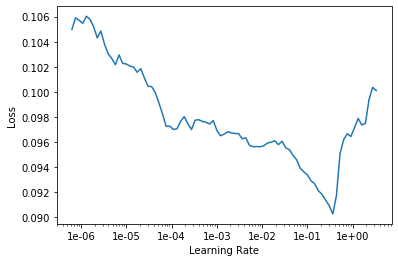

In [39]:
lr_find(learn)
learn.recorder.plot()

In [40]:
lr = 1e-03

In [41]:
learn.fit_one_cycle(30, lr, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="valid_loss", mode="min", patience=7),
                                      SaveBestCallback(learn, monitor='valid_loss',mode='min', 
                                                       name='data_science_bowl_best_model_2')])

epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.082790,0.083435,0.345777,00:04
1,0.079695,0.082450,0.374819,00:04
2,0.074944,0.078908,0.413202,00:04
3,0.069792,0.073481,0.489605,00:04
4,0.067107,0.069252,0.511852,00:04
5,0.064490,0.070230,0.514815,00:04
6,0.063167,0.070405,0.503005,00:04
7,0.063246,0.069510,0.516203,00:04
8,0.060275,0.068275,0.523652,00:04
9,0.061398,0.067130,0.529955,00:04


Better model found at epoch 0 with valid_loss value: 0.08343531936407089.
Better model found at epoch 1 with valid_loss value: 0.08245012164115906.
Better model found at epoch 2 with valid_loss value: 0.07890849560499191.
Better model found at epoch 3 with valid_loss value: 0.0734812393784523.
Better model found at epoch 4 with valid_loss value: 0.06925177574157715.
Better model found at epoch 8 with valid_loss value: 0.0682753473520279.
Better model found at epoch 9 with valid_loss value: 0.06712962687015533.
Better model found at epoch 14 with valid_loss value: 0.06692620366811752.
Epoch 22: early stopping
learn best 0.06692620366811752 data_science_bowl_best_model_2


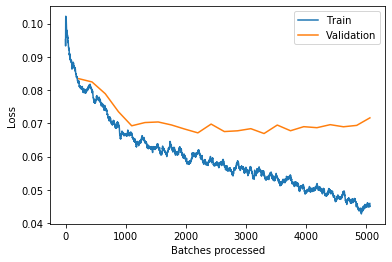

In [42]:
learn.recorder.plot_losses()

In [43]:
learn.fit_one_cycle(20, lr / 10, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="valid_loss", mode="min", patience=7),
                                            SaveBestCallback(learn, monitor='valid_loss',mode='min', name='data_science_bowl_best_model_3')])

epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.051255,0.067281,0.540468,00:04
1,0.051077,0.067505,0.542065,00:04
2,0.050540,0.067328,0.545085,00:04
3,0.050470,0.067412,0.542086,00:04
4,0.050656,0.067619,0.535220,00:04
5,0.049353,0.068000,0.534189,00:04
6,0.048787,0.067768,0.539900,00:04
7,0.048729,0.068290,0.530875,00:04


Better model found at epoch 0 with valid_loss value: 0.06728052347898483.
Epoch 8: early stopping
learn best 0.06692620366811752 data_science_bowl_best_model_2


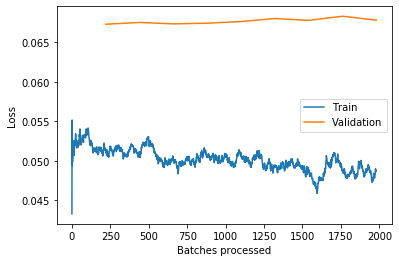

In [44]:
learn.recorder.plot_losses()

In [45]:
learn.fit_one_cycle(20, lr / 100, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="valid_loss", mode="min", patience=7),
                                            SaveBestCallback(learn, monitor='valid_loss',mode='min', name='data_science_bowl_best_model_4')])

epoch,train_loss,valid_loss,kappa_score_regression,time
0,0.051013,0.067310,0.544075,00:04
1,0.051853,0.066701,0.544713,00:04
2,0.049436,0.066522,0.545449,00:04
3,0.051908,0.067778,0.535918,00:04
4,0.050127,0.066857,0.543246,00:04
5,0.049869,0.067398,0.541501,00:04
6,0.051145,0.067473,0.536018,00:04
7,0.051085,0.066285,0.547856,00:04
8,0.050432,0.066774,0.545078,00:04
9,0.049562,0.067314,0.542767,00:04


Better model found at epoch 0 with valid_loss value: 0.06731042265892029.
Better model found at epoch 1 with valid_loss value: 0.06670127809047699.
Better model found at epoch 2 with valid_loss value: 0.0665222704410553.
Better model found at epoch 7 with valid_loss value: 0.0662851631641388.
Epoch 15: early stopping
learn best 0.0662851631641388 data_science_bowl_best_model_4


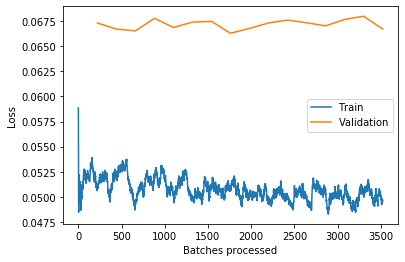

In [46]:
learn.recorder.plot_losses()

## Inference

In [47]:
preds_train, y = learn.get_preds(ds_type=DatasetType.Valid)
labels_train = preds_train.flatten()
opt = OptimizedRounder(optim_initial_coeff, labels=[0, 1, 2, 3])
y_converted = [feature_engineering.convert_to_accuracy_group(x) for x in y]
opt.fit(labels_train, y_converted)

In [48]:
coefs = opt.coefficients(); coefs

array([0.25949 , 0.531358, 0.651986])

In [49]:
cohen_kappa_score(rounder(preds_train.flatten(), coefs), y_converted, weights="quadratic")

0.5478562744818205

In [50]:
preds, y = learn.get_preds(ds_type=DatasetType.Test)
labels = preds.flatten()

In [51]:
labels = rounder(labels, coefs)

### Data Checks

In [67]:
valid_ds = comp_train_df[comp_train_df.index.isin(valid_idx)].groupby('installation_id').last()['accuracy']
expected_ratios = valid_ds.apply(lambda x : feature_engineering.convert_to_accuracy_group(x)).value_counts(normalize=True)
expected_ratios

3    0.450747
0    0.283066
1    0.137244
2    0.128943
Name: accuracy, dtype: float64

In [71]:
pred_ratios = pd.Series(labels).value_counts(normalize=True)
pred_ratios
# 5.11
# 3    0.477
# 2    0.221
# 0    0.180
# 1    0.122

# 4.68
# 3    0.448
# 2    0.265
# 0    0.189
# 1    0.098

3    0.456
2    0.216
0    0.171
1    0.157
dtype: float64

In [85]:
pred_ratios_list = np.array(pred_ratios.sort_index().tolist())
expected_ratios_list = np.array(expected_ratios.sort_index().tolist())
pred_ratios_list, expected_ratios_list

(array([0.171, 0.157, 0.216, 0.456]),
 array([0.283066, 0.137244, 0.128943, 0.450747]))

In [86]:
prod = ((pred_ratios_list - pred_ratios_list.mean()) * (expected_ratios_list - expected_ratios_list.mean())).mean() / (pred_ratios_list.std() * expected_ratios_list.std())
prod

0.8412042842213336

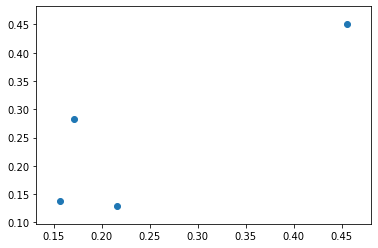

In [84]:
plt.scatter(pred_ratios_list, expected_ratios_list);

## Submission

In [54]:
submission_df = pd.DataFrame({'installation_id': comp_test_df['installation_id'], 'accuracy_group': labels})
submission_df

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
...,...,...
995,fee254cf,3
996,ff57e602,0
997,ffc73fb2,3
998,ffe00ca8,1


In [55]:
def prepare_submission(submission_df):
    sample_submission_df = pd.read_csv(path/'sample_submission.csv')
    sample_submission_df.drop('accuracy_group', inplace = True, axis = 1)
    sample_submission_df = sample_submission_df.merge(submission_df, on = 'installation_id')
    sample_submission_df = sample_submission_df[['installation_id', 'accuracy_group']]
    sample_submission_df.to_csv('submission.csv', index = False)

In [56]:
prepare_submission(submission_df)

In [57]:
!head submission.csv

installation_id,accuracy_group
00abaee7,3
01242218,3
017c5718,3
01a44906,3
01bc6cb6,3
02256298,3
0267757a,3
027e7ce5,3
02a29f99,0


In [58]:
!cat submission.csv | wc -l

1001


## Feature Importance

In [59]:
def feature_importance(learn:Learner): 
    pd.options.mode.chained_assignment = None
    # based on: https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
    data = learn.data.train_ds.x
    cat_names = data.cat_names
    cont_names = data.cont_names
    loss0=np.array([learn.loss_func(learn.pred_batch(batch=(x,y.to("cpu"))), y.to("cpu")) for x,y in iter(learn.data.valid_dl)]).mean()
    #The above gives us our ground truth percentage for our validation set
    fi=dict()
    types=[cat_names, cont_names]
    with tqdm(total=len(data.col_names)) as pbar:
      for j, t in enumerate(types): # for all of cat_names and cont_names
        for i, c in enumerate(t):
          loss=[]
          for x,y in (iter(learn.data.valid_dl)): # for all values in validation set
            col=x[j][:,i] # select one column of tensors
            idx = torch.randperm(col.nelement()) # generate a random tensor
            x[j][:,i] = col.view(-1)[idx].view(col.size()) # replace the old tensor with a new one
            y=y.to('cpu')
            loss.append(learn.loss_func(learn.pred_batch(batch=(x,y)), y))
          pbar.update(1)
          fi[c]=np.array(loss).mean()-loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    
    df = pd.DataFrame({'Variable': [l for l, v in d], 'Importance': np.log1p([v for l, v in d])})
    df['Type'] = ''
    for x in range(len(df)):
      if df['Variable'].iloc[x] in cat_names:
        df['Type'].iloc[x] = 'categorical'
      if df['Variable'].iloc[x] in cont_names:
        df['Type'].iloc[x] = 'continuous'
    return df

In [60]:
feature_importance = feature_importance(learn);

In [61]:
feature_importance.head(20)

,Variable,Importance,Type
0,session_title,0.045891,categorical
1,accumulated_accuracy_group,0.000695,continuous
2,accumulated_accuracy,0.000689,continuous
3,9d4e7b25,0.000378,continuous
4,7372e1a5,0.000366,continuous
5,4070Chow Time,0.000329,continuous
6,6d90d394,0.000312,continuous
7,3120,0.000295,continuous
8,Assessment_time_mean,0.000290,continuous
9,activity_game_time_Game,0.000289,continuous
